# Выбор локации для скважины

Добывающей компания «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Возможную прибыль и риски техникой будем анализировать техникой *Bootstrap.*

От заказчика в качестве исходных данных получена информация о шагах выполянемых при выборе локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
df0 = pd.read_csv('C:/Users/hk/Desktop/практика/датасеты/geo_data_0.csv')
df1 = pd.read_csv('C:/Users/hk/Desktop/практика/датасеты/geo_data_1.csv')
df2 = pd.read_csv('C:/Users/hk/Desktop/практика/датасеты/geo_data_2.csv')

Напишем функцию для предоставления информации о датафреймах, проверки данных в них на пропуски, явные дубликаты, и построения гистограмм по каждому столбцу датафреймов

In [3]:
def check(data):
    display(data.head())
    print(f'Размеры датафрейма: {data.shape}')
    print('Количество пропусков:', data.isna().sum())
    print('Количество явных дубликатов', data.duplicated().sum())
    print('Распределение признаков')
    data[['f0', 'f1', 'f2', 'product']].hist()
    plt.show()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Размеры датафрейма: (100000, 5)
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов 0
Распределение признаков


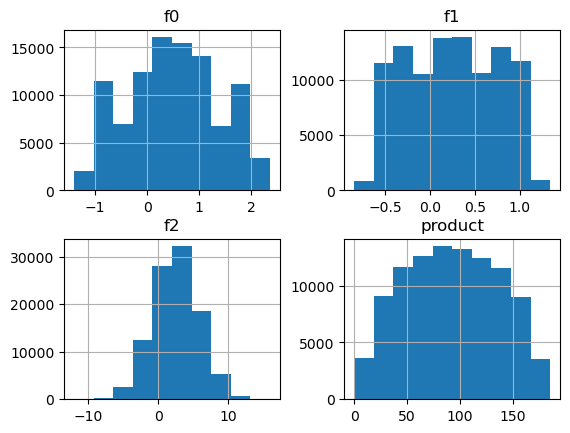

In [4]:
check(df0)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Размеры датафрейма: (100000, 5)
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов 0
Распределение признаков


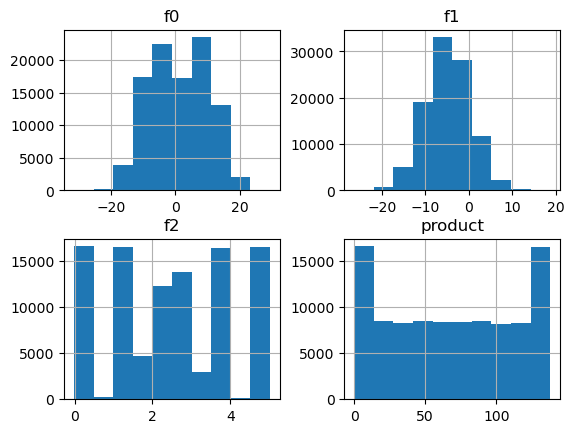

In [5]:
check(df1)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Размеры датафрейма: (100000, 5)
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов 0
Распределение признаков


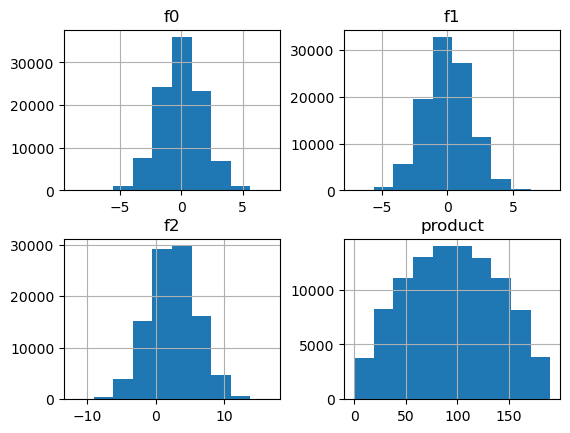

In [6]:
check(df2)

Так как столбец с номерами ID не имеет значимости для обучения модели, удалим этот столбец иих всех датафреймов

In [7]:
df0 = df0.drop(['id'], axis=1)
df1 = df1.drop(['id'], axis=1)
df2 = df2.drop(['id'], axis=1)

In [8]:
df0.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


По результатам предварительного анализа, можно сказать, что во всех регионах признаками являются данные, находящиеся в столбцах:
- `f0`
- `f1`
- `f2`

Целевым признаком, являются данные, находящиеся в столбце `product`.
Из полученных гистограмм видно, что в 1 и 3 регионах данные в столбце с целевым признаком распределены почти нормально, что нельзя сказать о целевом признаке второго региона. Посмотрим подробнее на данные в этом столбце.

Напишем функцию, которая определяет количество нулевых значений в столбце с целевым признаком

In [9]:
def check_zeroes(data, name):
    zeroes = data[data[name] == 0][name].count()
    persent = zeroes / len(data)
    print('Количество нулевых значений:', zeroes)
    print('Доля нулевых значений:', persent)

In [10]:
check_zeroes(df0, 'product')

Количество нулевых значений: 1
Доля нулевых значений: 1e-05


In [11]:
check_zeroes(df1, 'product')

Количество нулевых значений: 8235
Доля нулевых значений: 0.08235


In [12]:
check_zeroes(df2, 'product')

Количество нулевых значений: 1
Доля нулевых значений: 1e-05


**Вывод по разделу 1**

На входе у нас данные геологоразведки трех регионов, находящиеся в трех файлах. После выгрузки и анализа данных установлено, что в данных нет пропусков и дубликатов, признаки в регионах 1 и 3 распределены нормально. Однако в признаках региона 2 обнаружено 8,2% нулевых значений, что может говорить об утерянности данных или отсутствию исследований по признаку `f2`.

Для обучения модели будем считать признаками данные, находящиеся в столбцах `f0`, `f1`, `f2`, а целевым признаком данные в столбце `product`.

## Обучение и проверка модели

Напишем функцию для разбивки данных на тренировочную и валидационную выборки, обучение модели линейной регрессии, подсчета среднего запаса предсказанного сырья и RMSE модели

In [13]:
model = LinearRegression()

def learning(data, target):
    features = data.drop([target], axis=1)
    target = data[target]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    dataframe = {'real_product' : target_valid,
                'prediction_product' : predictions_valid}
    data_frame = pd.DataFrame(dataframe, columns=['real_product', 'prediction_product'])
   
    
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    mean = data_frame['prediction_product'].mean()
    summa = data_frame['prediction_product'].sum()
    
    return data_frame, rmse, mean, summa 

### Обучение модели, расчет RMSE и среднего запас предсказанного сырья для 1 региона

In [14]:
df0_predicted, df0_rmse, df0_mean, df0_sum = learning(df0, 'product')
display(df0_predicted.head())
print('Значение RMSE для 1 региона:', df0_rmse)
print('Средний запас предсказанного сырья:', df0_mean)

,real_product,prediction_product
71751,10.038645,95.894952
80493,114.551489,77.572583
2655,132.603635,77.892640
53233,169.072125,90.175134
91141,122.325180,70.510088


Значение RMSE для 1 региона: 37.5794217150813
Средний запас предсказанного сырья: 92.59256778438035


In [15]:
predictions_0 = df0_predicted['prediction_product']
target_0 = df0_predicted['real_product'] #сохраняем предсказания и правильные ответы для 1 региона

### Обучение модели, расчет RMSE и среднего запас предсказанного сырья для 2 региона

In [16]:
df1_predicted, df1_rmse, df1_mean, df1_sum = learning(df1, 'product')
display(df1_predicted.head())
print('Значение RMSE для 1 региона:', df1_rmse)
print('Средний запас предсказанного сырья:', df1_mean)

,real_product,prediction_product
71751,80.859783,82.663314
80493,53.906522,54.431786
2655,30.132364,29.748760
53233,53.906522,53.552133
91141,0.000000,1.243856


Значение RMSE для 1 региона: 0.8930992867756168
Средний запас предсказанного сырья: 68.72854689544602


In [17]:
predictions_1 = df1_predicted['prediction_product']
target_1 = df1_predicted['real_product'] #сохраняем предсказания и правильные ответы для 2 региона

### Обучение модели, расчет RMSE и среднего запас предсказанного сырья для 3 региона

In [18]:
df2_predicted, df2_rmse, df2_mean, df2_sum = learning(df2, 'product')
display(df2_predicted.head())
print('Значение RMSE для 1 региона:', df2_rmse)
print('Средний запас предсказанного сырья:', df2_mean)

,real_product,prediction_product
71751,61.212375,93.599633
80493,41.850118,75.105159
2655,57.776581,90.066809
53233,100.053761,105.162375
91141,109.897122,115.303310


Значение RMSE для 1 региона: 40.02970873393434
Средний запас предсказанного сырья: 94.96504596800489


In [19]:
predictions_2 = df2_predicted['prediction_product']
target_2 = df2_predicted['real_product'] #сохраняем предсказания и правильные ответы для 3 региона

### Оценка суммарного запаса по регионам по предсказанным данным

In [20]:
print('Суммарный предсказанный запас в 1 регионе:', df0_sum)
print('Суммарный реальный запас в 1 регионе:', df0_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в 2 регионе:', df1_sum)
print('Суммарный реальный запас в 2 регионе:', df1_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в 3 регионе:', df2_sum)
print('Суммарный реальный запас в в 3 регионе:', df2_predicted['real_product'].sum())

Суммарный предсказанный запас в 1 регионе: 2314814.194609509
Суммарный реальный запас в 1 регионе: 2301964.918520732

Суммарный предсказанный запас в 2 регионе: 1718213.6723861503
Суммарный реальный запас в 2 регионе: 1718078.4006089992

Суммарный предсказанный запас в 3 регионе: 2374126.1492001223
Суммарный реальный запас в в 3 регионе: 2372105.8202213594


**Вывод по разделу 2** 

Для трех исследуемых регионов с помощью функции выполнили следующие действия:

- разделили данные на тренировочную и валидационную выборки в соотношении 75:25;
- обучили модель линейной регрессии и сформировали предсказания на валидационной выборке;
- сохранили предсказания и правильные ответы в отдельный переменных `predictons_0`, `target_0`, `predictons_1`, `target_1`, `predictons_2`, `target_2` соответственно;
- рассчитали и вывели на экран значения RMSE и средний запас предсказанного сырья модели для каждого региона.

По результатам выполненных действий, получили что значения RMSE, а также средний запас предсказанного сырья для 1 и 3 региона примерно одинаковые и составляют:

- `RMSE_0 = 37.57`, `mean_0 = 92.59`
- `RMSE_2 = 40.02`, `mean_2 = 94.96`

В отличие от второго региона, где полученно: `RMSE_1 = 0.89`, `mean_2 = 68.72`. Можно сказать, что модель для второго региона предсказывает лучше всех, так как значение RMSE минимальное, но это может быть так же обусловлено тем, что из-за приличного количества нулевых значений в признаке `f2` модель могла переобучиться.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных

In [21]:
BUDGET = 1e+07 #так как мы будем расчитывать прибыль в тысячах рублей, миллиард сохраним таким образом
COMMON_POINTS = 500
BEST_POINTS = 200
BARREL_PRICE = 450

Расчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [22]:
average_profit_per_point = BUDGET / BEST_POINTS
print('Средняя прибыль на лучшую точку:', average_profit_per_point, 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / BARREL_PRICE
print('Средний объем нефти на точку:', average_barrels_per_point, 'тыс. барелей')

average_barrels = BUDGET / BARREL_PRICE
print('Средний объем нефти на регион:',average_barrels, 'тыс. барелей')

Средняя прибыль на лучшую точку: 50000.0 тыс.руб.
Средний объем нефти на точку: 111.11111111111111 тыс. барелей
Средний объем нефти на регион: 22222.222222222223 тыс. барелей


Отобразим средний запас фактическией на скважину по каждому региону

In [23]:
print('Средний запас фактичекой нефти на скважину в регионе 1:', df0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2:', df1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3:', df2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1: 92.50000000000001
Средний запас фактичекой нефти на скважину в регионе 2: 68.82500000000002
Средний запас фактичекой нефти на скважину в регионе 3: 95.00000000000004


**Вывод по разделу 3**

В данном разделе была подготовлена средняя оценка прибыли за одну скважину и средний объем на одну скважину. 
Анализ полученных значений показал следующее:

- для первого региона модель предсказала средний запас сырья равный = 92.59, что близко к реальному 92.5
- для второго региона модель предсказала средний запас сырья равный = 68.72, что так же близко к реальному в 68.82
- аналогичная ситуация и для третьего региона, где запас предсказанный = 94.96, практически соответствует реальному 95.00.

Так как по полученным значениям о среднем значении нефти на точку для безубыточной разработки скважин необходим средний объем нефти на скважину равный 111 тыс.барелей, наиболее близкие к этому значения имеют регионы 1 и 3. Во втором регионе это значение сильно меньше, но опять же, это может быть вызвано нулевыми значениями в призанке `f2`, который по возможности нужно уточнить.

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли

In [24]:
def profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return BARREL_PRICE * selected.sum() - BUDGET

In [25]:
state = np.random.RandomState(12345)

In [26]:
def bootstrap(target, probabilities):
    values=[]
    for i in range(1000):
        target_subsample = target.sample(n=COMMON_POINTS, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        profit = profit_calculation(target, probs_subsample, BEST_POINTS)
        values.append(profit)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = (values < 0).mean()
    
    return average, lower, upper, risk

In [27]:
average_0, lower_0, upper_0, risk_0 = bootstrap(target_0, predictions_0)
print('Данные по ПЕРВОМУ региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по ПЕРВОМУ региону.
Средняя прибыль по региону = 396164.98 тыс.руб.
95% доверительный интервал от -111215.55 до 909766.94 тыс.руб.
Процент риска 6.90%


In [28]:
average_1, lower_1, upper_1, risk_1 = bootstrap(target_1, predictions_1)
print('Данные по ВТОРОМУ региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по ВТОРОМУ региону.
Средняя прибыль по региону = 461155.82 тыс.руб.
95% доверительный интервал от 78050.81 до 862952.06 тыс.руб.
Процент риска 0.70%


In [29]:
average_2, lower_2, upper_2, risk_2 = bootstrap(target_2, predictions_2)
print('Данные по ПЕРВОМУ региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по ПЕРВОМУ региону.
Средняя прибыль по региону = 392950.48 тыс.руб.
95% доверительный интервал от -112227.63 до 934562.91 тыс.руб.
Процент риска 6.50%


## Итоговый вывод

Нашей задачей являлось на основе данных геологоразведки трёх регионов с помощью машинного обучения модели линейной регрессии определить регион, где добыча принесёт наибольшую прибыль.

На 1 певром этапе провдена 
Для **региона 1** на вход получен датафрейм с размерами (10000, 5), в котором признаки `f0`, `f1`, `f2`, а также целевой признак `product` распределены близко к нормальному.
Для **региона 2** на вход получен датафрейм с размерами (10000, 5), в котором признаки `f0`, `f1` распределены близко к нормальному, а в столбце из-за нулевых значений (8,2% от всех значений в данном признаке) распределение отличается от нормального, как и  целевой признак `product`.
Для **региона 3** на вход получен датафрейм с размерами (10000, 5), в котором признаки `f0`, `f1`, `f2`, а также целевой признак `product` распределены близко к нормальному.

Для всех датафреймов была проведена проверка на наличие пропусков и явных дубликатов. Ни того ни другого не обнаружено. 
Так же на этапе предобработки из данных обо всех регионах были удалены столбцы с указанием ID, так как  для обучения моделей они не нужны.

На втором этапе была написана функция для разделения датафреймов на обучающие и валидационные выборки в соотношении 75:25, обученения модели линейной регрессии и получения предсказаний по валидационной выборке. Для всех регионов в отдельных переменных сохранены предсказания и правильные ответы, полученные на валидационной выборке. Расчитаны значения RMSE и  средний запас предсказанного сырья, получены следующие значения:

- **регион 1** `RMSE_0 = 37.57`, `mean_0 = 92.59`
- **регион 2** `RMSE_1 = 0.89`, `mean_1 = 68.72`
- **регион 3** `RMSE_2 = 40.02`, `mean_2 = 94.96`

Можно сказать, что модель для **региона 2** предсказывает лучше всех, так как значение RMSE минимальное, но это может быть так же обусловлено тем, что из-за приличного количества нулевых значений в признаке `f2` модель могла переобучиться.

На третьем этапе были подготовлены данные для расчета прибыли. Все ключевые значения о количестве исследуемых точек, бюджете на разработку, доходов на 1 баррель сохранены в отдельных переменных. Расчитан достаточный объем сырья для безубыточной разработки новой скважины, который составляет 111 тыс. барелей. Для **региона 1** и **региона 3** средние предсказанные значения получились близкие к этом (92,59 и 94,96), что нельзя сказать о **регионе 2** (68,72). 

На четвертом этапе написана функция для расчёта прибыли по выбранным скважинам и предсказаниям модели. 

На пятом этапе на основе написанной функции с помощью метода Bootstrap  расчитаны риски и прибыль, а также определен доверительный интервал. Получены следующие значения:

1) для **региона 1**:

- прибыль составляет 396164.98 тыс.руб.;
- доверительный интервал -111215.55 до 909766.94 тыс.руб.;
- процент риска - 6.90%

2) для **региона 2**:

- прибыль составляет 461155.82 тыс.руб.;
- доверительный интервал 78050.81 до 862952.06 тыс.руб.;
- процент риска - 0.70%

3) для **региона 3**:

- прибыль составляет 392950.48 тыс.руб.;
- доверительный интервал -112227.63 до 934562.91 тыс.руб;
- процент риска - 6.50%

С учетом полученных значений прибыли, доверительного интервала и процента рисков, рекомендую выбрать **регион 2** для бурения новых скважин, так как прибыль больше, а процент рисков меньше, по сравнению с двумя другими регионами. Однако для большей уверенности необходимо выяснить причины наличия нулевых значений в признаках описывающих **регион 2** и в случае обновления данных повторить обучение модели уже с новыми данными. 